# Imports

In [1]:
# Common imports
import numpy as np
import os
import io
import warnings

#sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# To plot pretty figures
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Suppress all the warnings
warnings.filterwarnings('ignore')

### Data Loading

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
X = X.to_numpy()
y = y.to_numpy()

In [5]:
target_names = np.unique(y)
print('Number of samples: {0}, type: {1}'.format(X.shape[0], X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum: {0},Maximum:{1}'.format(np.min(X), np.max(X)))
print('Number of classes: {0}, type: {1}'.format(len(target_names), y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type: int64
Number of features: 784
Minimum: 0,Maximum:255
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


- The MNIST dataset is clean and the range of values that each feature can take
  is also known. Therefore, the samples in the dataset may not require many data
  preprocessing techniques.
- However, it is often better to scale the range of **features between 0 to 1**.
- So, we can either use MinMaxScaler or MaxAbsScaler.They don't make any
  difference as the **image pixels can takes only positive values from 0 to 255**.

In [9]:
X = MinMaxScaler().fit_transform(X)
print(f"Minimum value: {np.min(X)}, Maximum value: {np.max(X)}")

Minimum value: 0.0, Maximum value: 1.0


# Data Visualization
- Let us pick a few images and display them with their respective labels.
- Images are as a row vector of **size 1 x 784 and therefore must be reshaped**
  to the matrix of size 28 x 28 to display them properly.

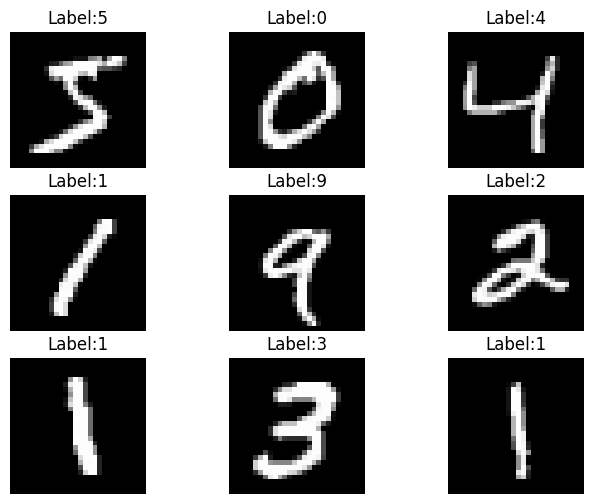

In [11]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor,ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index = idx_offset+i*(factor)
    for j in range (factor):
        ax[i, j].imshow(X[index+j].reshape(28, 28) , cmap='gray')
        ax[i, j].set_title('Label:{0}'.format (str(y[ index+j])))
        ax[i, j].set_axis_off()

# Data Splitting
- Let us spilt the total number of samples into train and test set in the
  following ratio: 60000/10000.
- Since the samples in the data set are **already randomly shuffled**, we need not
  to shuffle it again.Therefore using **`train_test_split()` may be skipped**.

In [14]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- We need to check whether the dataset is balanced or imbalanced.
- We can do it by plotting the distribution of samples in each classes.

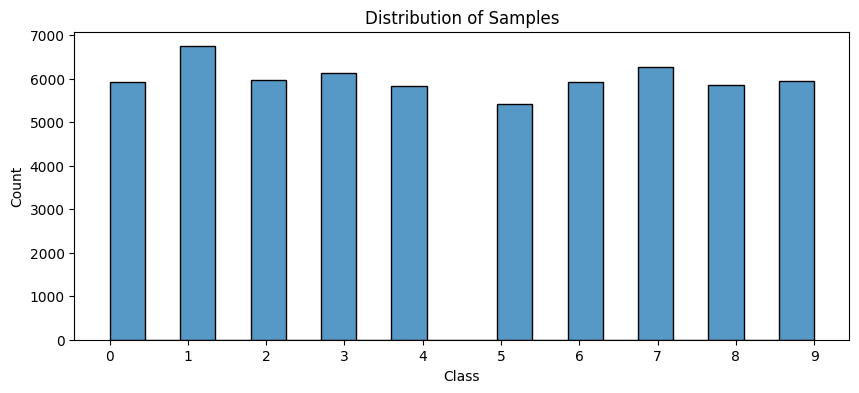

In [15]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2, 3,4,5, 6, 7, 8, 9], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] )
plt.xlabel ('Class')
plt.title('Distribution of Samples')
plt. show()

# Binary Classification: 0-Detector
<br>

### Modifying Labels
- Let us start with a simple classification problem, that is, binary classification.
- Since the original label vector contains 10 classes, we need to modfiy the number of classes to 2
- Therefore, the label **0 will be changed to 1** and **all other labels (1-9) will be changed to -1**.
- We name the label vectors as y_train_0 and y_test_0.

In [16]:
y_train_0 = -1 * np.ones(len(y_train))
y_test_0 = -1 * np.ones(len(y_test))

indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

### Sanity Check

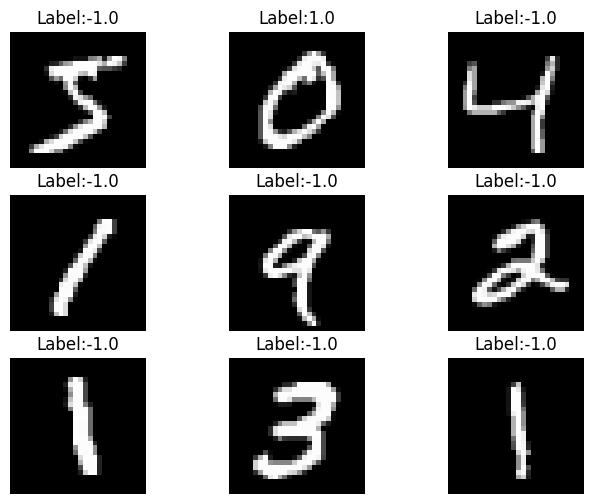

In [17]:
num_images = 9
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor,ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index = idx_offset+i*(factor)
    for j in range (factor):
        ax[i, j].imshow(X[index+j].reshape(28, 28) , cmap='gray')
        ax[i, j].set_title('Label:{0}'.format (str(y_train_0[ index+j])))
        ax[i, j].set_axis_off()

# Baseline Model
1. Count number of samples per class.
2. The model always outputs the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.

In [19]:
num_pos = len(np.where(y_train_0 == 1) [0])
num_neg = len(np.where(y_train_0 == -1) [0])
print(f'Number of positives = {num_pos}')
print(f'Number of negatives = {num_neg}')

Number of positives = 5923
Number of negatives = 54077


In [20]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(x_train,y_train_0)
print('Training accuracy: {0:.2f}'.format(base_clf.score(x_train, y_train_0)))
print('Testing accuracy: {0:.2f}'.format(base_clf.score(x_test,y_test_0)))

Training accuracy: 0.90
Testing accuracy: 0.90


Now the reason is obvious. The model would have predicted 54077 sample correctly just by outputing -1 for all the input
samples.Therefore the accuracy will be $\frac{54077}{60000}$

# Perceptron Model

In [21]:
bin_clf = Perceptron(max_iter=100, random_state=1729)

In [24]:
bin_clf.fit(x_train,y_train_0)
print('Dimension of Weights w: {0}'.format(bin_clf.coef_.shape) )
print('Bias :{0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimension of Weights w: (1, 784)
Bias :[-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x00000172716C1DF0>


In [28]:
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy: ',bin_clf.score(x_train, y_train_0))

Training Accuracy:  0.99095


In [1]:
print('Training Accuracy: ',bin_clf.score(x_test, y_test_0))

NameError: name 'bin_clf' is not defined

# Displaying Predictions
- Take few images from the test set at random and **display it with the corresponding predictions**.
- Plot a few images in a single figure window along with their respective predictions.

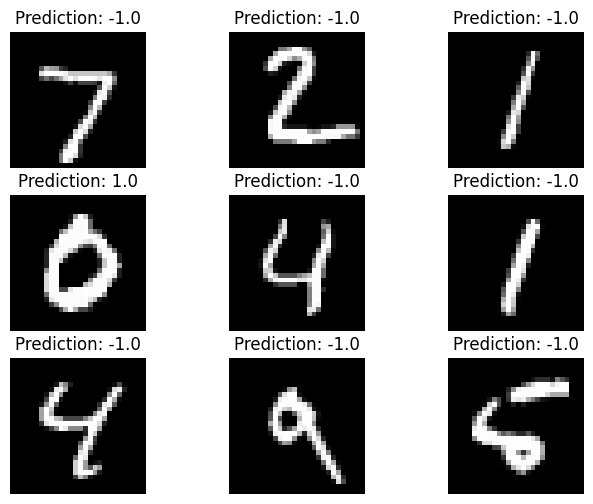

In [31]:
y_hat_test_0 = bin_clf.predict(x_test)
num_images = 9
factor = int(np.sqrt(num_images) )
fig, ax = plt.subplots(nrows=factor,ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index = idx_offset+i*(factor)
    for j in range(factor):
        ax[i, j].imshow(x_test[index+j].reshape(28, 28) , cmap='gray')
        ax[i, j].set_title('Prediction: {0}'.format(str(y_hat_test_0[index+j])))
        ax[i, j].set_axis_off()

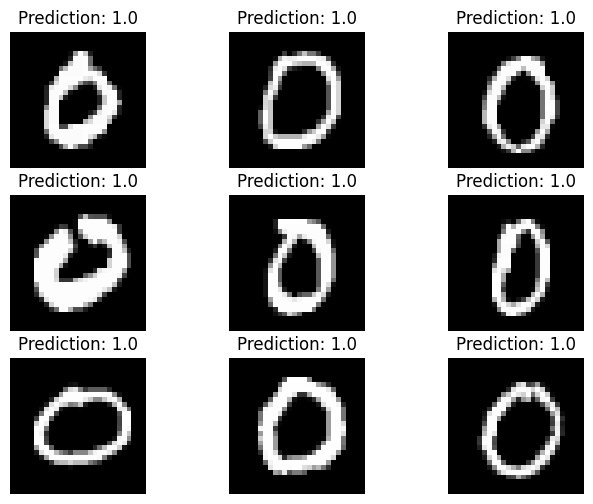

In [33]:
indx_0 = np.where(y_test_0 == 1)
zeroImgs = x_test[indx_0 [0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor,ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index = idx_offset+i*(factor)
    for j in range(factor):
        ax[i, j].imshow(zeroImgs [index+j]. reshape(28, 28) , cmap='gray')
        ax[i, j].set_title('Prediction: {0}'.format(str(zeroLabls[index+j])))
        ax[i, j].set_axis_off()

In [38]:
num_misclassified = np.count_nonzero(zeroLabls == -1)
num_correctpred = len(zeroLabls)-num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print (accuracy)

0.9193877551020408


- This above score (guess the name of the metric) is less than the accuracy
  score of the model but it seems pretty descent.

### Confusion Matrix

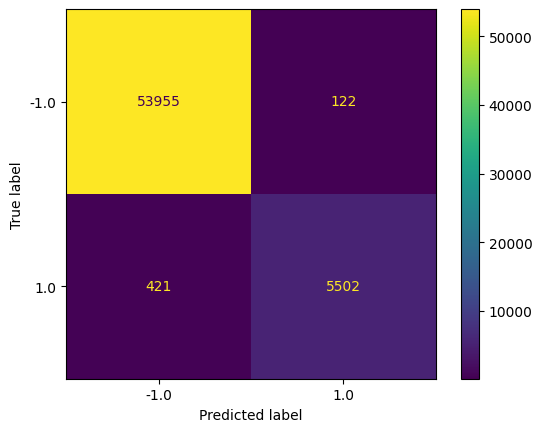

In [39]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

### Precision and Recall

In [40]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp+fp)
print('Precision: ',precision)
recall = tp/(tp+fn)
print('Recall: ',recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy: ', accuracy)

Precision:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy:  0.99095


- The precision is close to 0.98.
- **Suppose we still want to increase the precision**.

# Cross Validation
- Well, to address this, we have to use cross-validation folds and measure the
  same metrics across these folds for different values of hyper-parameters.
- However, perceptron does not many hyper parameters other than the learning rate.

In [51]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, x_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_estimator=True)

In [52]:
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.04543972, 1.8632803 , 1.38366723, 1.42243886, 1.70480871]),
 'score_time': array([0.43131232, 0.06755948, 0.03277946, 0.03381705, 0.03504109]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


In [53]:
print(f'Precision   |   avg: {scores["test_precision"].mean():.3f} | std: {scores["test_precision"].std():.3f}')
print(f'Recall      |   avg: {scores["test_recall"].mean():.3f} | std: {scores["test_recall"].std():.3f}')
print(f'F1          |   avg: {scores["test_f1"].mean():.3f} | std: {scores["test_f1"].std():.3f}')

Precision   |   avg: 0.963 | std: 0.013
Recall      |   avg: 0.924 | std: 0.035
F1          |   avg: 0.942 | std: 0.013


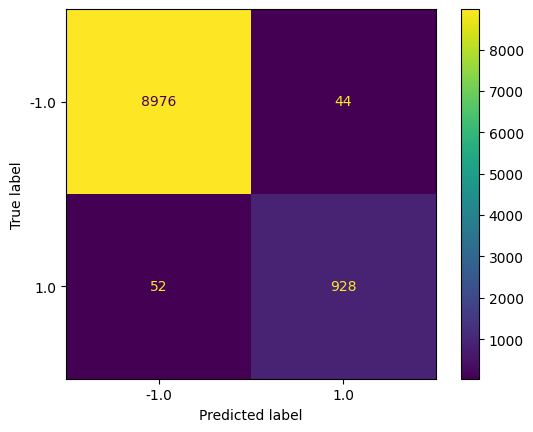

In [56]:
# Picking first estimator returned by the cross validation
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')
plt.show()

In [57]:
precision = precision_score(y_test_0, y_hat_test_0)
print('Precision: ',precision)

recall = recall_score(y_test_0, y_hat_test_0)
print('Recall: ',recall)

Precision:  0.9547325102880658
Recall:  0.9469387755102041


#### **Way-2 for Generalization**

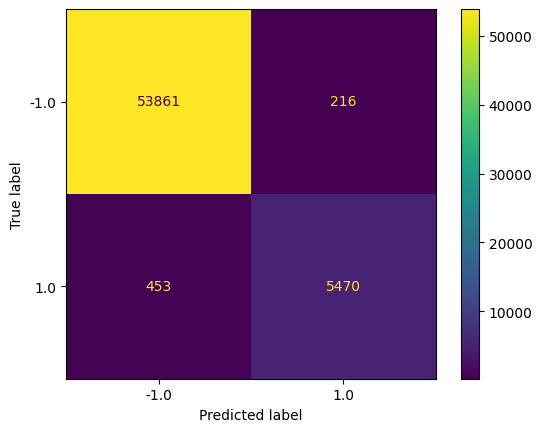

In [59]:
y_hat_train_0 = cross_val_predict(bin_clf, x_train, y_train_0, cv=5)

cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [60]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp+fp)
print('Precision: %.2f'%precision)
recall = tp/(tp+fn)
print ('Recall: %.2f'%recall)
f1=2/((1/precision)+(1/recall))
print('f1:%.2f'%f1)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy: %.2f'%accuracy)

Precision: 0.96
Recall: 0.92
f1:0.94
Accuracy: 0.99


In [61]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



# Precision/Recall Tradeoff
- Often time we need to make a trade off between precision and recall scores of a model.
- It depends on the problem at hand.
- It is important to note that we should not pass the predicted labels as input to precision_recall_curve function, instead we need to pass the probability scores or the output from the decision function.
- The Perceptron() class contains a decision_function method, therefore we can make use of it.
- Then, internaly the decision scores are sorted, tps and fps will be computed
  by changing the threshold from index[0] to index[-1].
- Let us compute the scores from the decision function.

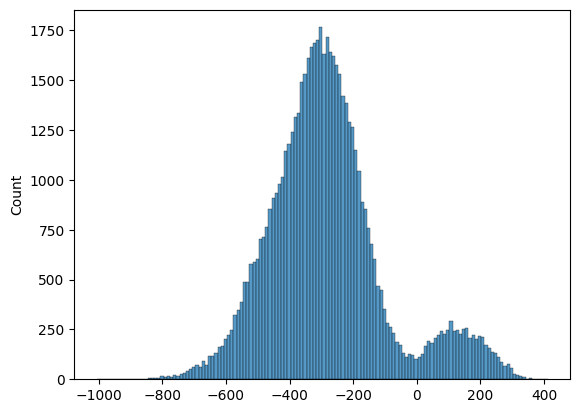

In [62]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(x_train,y_train_0)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

<details>
<summary>decision_function</summary>

# `decision_function`
The decision_function method of a binary classifier.

The decision boundary is the boundary that separates the two classes in the binary classification problem.

Samples that fall on one side of the boundary are classified as one class, while samples on the other side are classified as the other class.

The sign of the decision function score indicates which side of the boundary the sample falls on.

The magnitude of the decision function score indicates how far the sample is from the decision boundary.
</details>

*Can you think why there are so many negative values than the positives ?.*

- Suppose threshold takes the value of -600,then all the samples having score
  greater than -600 is set to 1(Positive label) and less than it is set to -1
  (neg label).

- Therefore, the number of False Positives will be increased. This will in turn
  reduce the precision score to a greater extent.

- On the otherhand, if the threshold takes the value of, say, 400. Then, the
  number of false negatives will be increase and hence the recall will reduce to
  a greater extent.

In [63]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

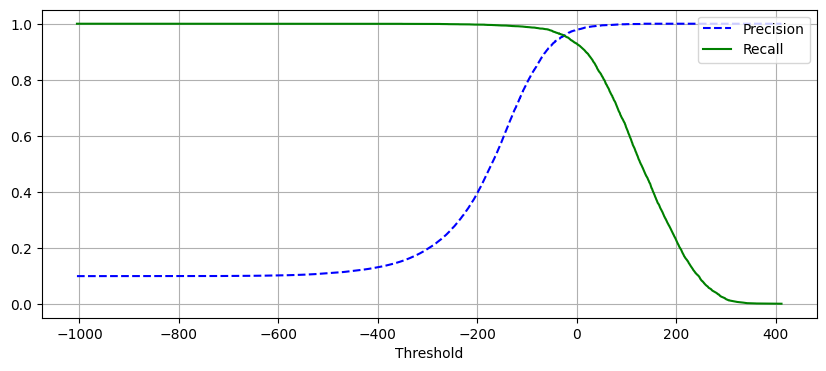

In [65]:
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[ :- 1], "b--", label="Precision")
plt.plot(thresholds, recalls[ :- 1], "g-", label="Recall")
plt.xlabel ('Threshold' )
plt.grid(True)
plt.legend(loc='upper right')
plt. show ()

In [66]:
#get the index of threshold around zero
idx_th = np.where(np.logical_and(thresholds>0,thresholds<1))
print('precision for zero threshold:',precisions[idx_th[0] [0]])

precision for zero threshold: 0.9783072546230441


# ROC Curve

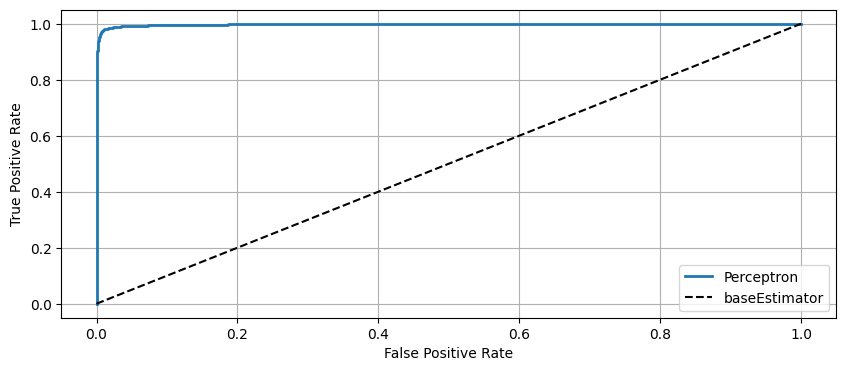

In [67]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0, 1], [0, 1], 'k--', label='baseEstimator')
plt.xlabel ('False Positive Rate')
plt.ylabel ('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

## Cold Start
- If we execute the fit method of bin_clf repeatedly, we get the same score for both training and testing accuracy.
- This because every time the fit method is called, the model weights are
  initialized to the same values. Therefore, we obtain the same score.
- This is termed as cold start. Let's execute the following cell 4 times and observe the score.

In [68]:
bin_clf.fit(x_train,y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy:',bin_clf.score(x_train, y_train_0))
print('Test accuracy: ',bin_clf.score(x_test,y_test_0))

Training Accuracy: 0.99095
Test accuracy:  0.989


## Warm Start

- As you might have guessed, there is an approach called Warm Start

- Setting `warm_start=True` retains the weight values of the model after max_iter and hence produce different results for each execution.

- Warm starting is useful in many ways.It helps us train the model by
  initializing the weight values from the previous state.So we can pause the
  training and resume it whenever we get the resource for computation.

- Of course, it is not required for simple models like perceptron and for a small dataset like MNIST.

- In this notebook, we use this feature to plot the iteration vs loss curve.

- Let us execute the following lines of code 4 times and observe how the training accuracy changes for each execution.

In [69]:
bin_clf_warm = Perceptron(max_iter=100, random_state=1729, warm_start=True)
bin_clf_warm.fit(x_train,y_train_0)
print('Training Accuracy:',bin_clf_warm.score(x_train, y_train_0))

Training Accuracy: 0.99095


<br>

---

<br>

# Multiclass Classifier (OneVsAll)
- We know that the perceptron is a binary classifier. However, MNIST dataset
  contains 10 classes.

- Solution: Combine multiple binary classifiers and devise a suitable scoring metric.

- Sklearn does this by counting a number of unique elements (10 in this case) in
  the label vector y_train and converting labels using LabelBinarizer to fit
  each binary classifer.

In [70]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer

In [72]:
clf = Perceptron(random_state=1729)

In [73]:
# let's use label binarizer just to see the encoding
y_train_ovr = LabelBinarizer().fit_transform(y_train) # setting sparse_output=True in LabelBinarizer() improves efficiency
for i in range(10):
    print('{0}:{1}'.format(y_train[i],y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


In [74]:
clf.fit(x_train, y_train)

Perceptron(random_state=1729)

- What had actually happened internally was that the API automatically created
  10 binary classifiers, converted labels to binary sparse matrix and trained
  them with the binarized labels !.
- During the inference time, the input will be passed through all these 10
  classifiers and the highest score among the output from the classifiers will be
  considered as the predicted class.
- To see it in action, let us execute the following lines of code

In [75]:
print('Shape of Weight matrix: {0} and bias vector: {1}'. format(clf.coef_.shape, clf.intercept_.shape))

Shape of Weight matrix: (10, 784) and bias vector: (10,)


- So it is a matrix of size 10 x 784 where each row represents the weights for a single binary classifier.
- Important difference to note is that there is no signum function associated with the perceptron.
- The class of a perceptron that outputs the maximum score for the input sample is considered as the predicted class.

In [76]:
scores = clf.decision_function(x_train[6].reshape(1,-1))
print (scores)
print('The predicted class: ',np.argmax(scores))

[[-631.88492118  154.366213    -65.23234141  -90.95338716 -189.29568627
  -137.14385236  -99.64604383 -159.09859285 -136.86391388 -199.26120723]]
The predicted class:  1


In [77]:
print('Preicted output:\n')
print(clf.predict(x_train[0].reshape(1,-1)))

Preicted output:

['5']


In [78]:
# get the prepdiction for all training samples
y_hat = clf.predict(x_train)

In [79]:
print(classification_report(y_train,y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



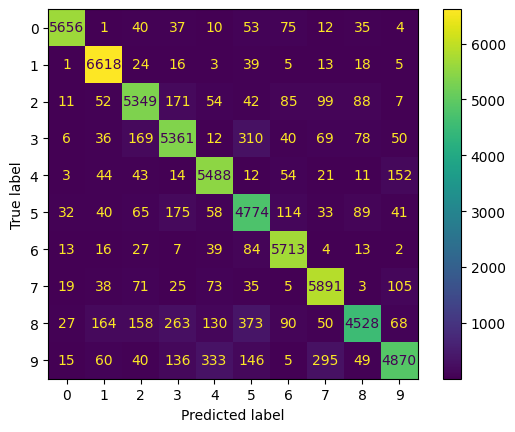

In [80]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat, values_format='.5g')


- What are all the insights we could infer from the above figure?
- Digit 2 is often confused with Digit 3 (Reasonable!).

# Making a Pipeline

- Let's create a pipeline to keep the code compact.
- Recall that, the MNIST dataset is clean and hence doesn't require much preprocessing.
- The one potential preprocessing technique we may use is to scale the features within the range (0,1)
- It is not similar to scaling down the range values between 0 and 1.

In [81]:
# create a list with named tuples
estimators = [('std_scaler', MinMaxScaler()), ('bin_clf' , Perceptron())]
pipe = Pipeline(estimators)

In [82]:
pipe.fit(x_train,y_train_0)

Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

In [83]:
Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron()) ])

Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

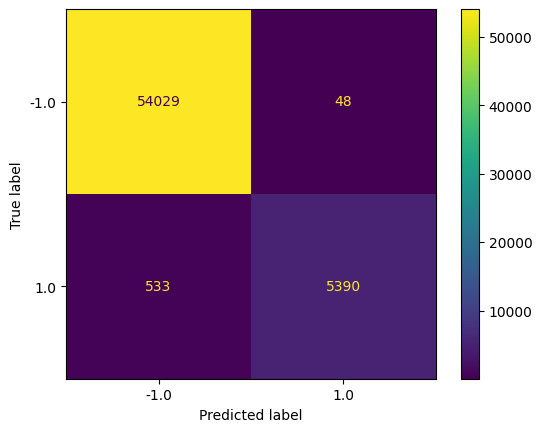

In [84]:
y_hat_train_0 = pipe.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0, values_format='.5g')
plt.show()

# Iteration vs Loss Curve
- The other way of **Plotting Iteration Vs Loss curve** with the Partial_fit method.

In [85]:
iterations = 100
bin_clf1= Perceptron(max_iter=1000,random_state=2094)
Loss_clf1 = []
for i in range(iterations):
    bin_clf1.partial_fit(x_train,y_train_0, classes=np.array([1,-1]))
    y_hat_0 = bin_clf1.decision_function(x_train)
    Loss_clf1.append(hinge_loss(y_train_0,y_hat_0))

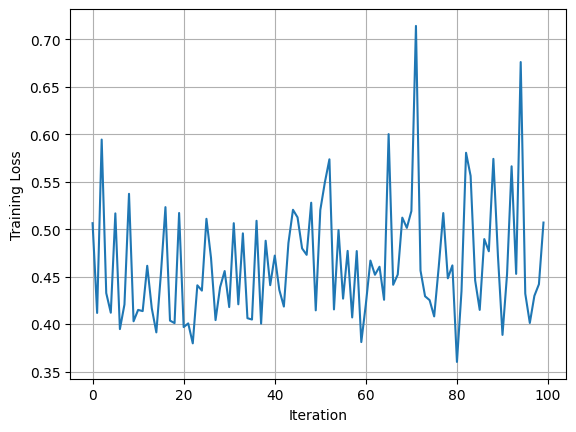

In [86]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1)
plt.grid(True)
plt.xlabel ('Iteration')
plt.ylabel ('Training Loss')
plt.show()

# GridSearchCV
- So far we didn't do any hyperparameter tuning. We accepted the default value for learning rate of the Perceptron class.
- Now, let us search for a better learning rate using GridSearchCV.
- No matter what the learning rate is, the loss will never converge to zero as the classes are not linearly separable.

In [2]:
[1/2 ** n for n in range(1,6)]

[0.5, 0.25, 0.125, 0.0625, 0.03125]

In [87]:
scoring = make_scorer(hinge_loss, greater_is_better=False)
lr_grid = [1/2 ** n for n in range(1,6)]
bin_clf_gscv = GridSearchCV(Perceptron(), param_grid={"eta0":lr_grid}, scoring=scoring, cv=5)
bin_clf_gscv.fit(x_train,y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False, response_method='predict'))

In [88]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([2.61819324, 3.13019214, 2.1109941 , 1.78540311, 2.1123868 ]),
 'mean_score_time': array([0.0724648 , 0.04586725, 0.03131671, 0.03549328, 0.05389824]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5]),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.04416667]),
 

In [89]:
iterations = 100
Loss = []
best_bin_clf = Perceptron(max_iter=1000,random_state=2094,eta0=0.125)
for i in range(iterations):
    best_bin_clf.partial_fit(x_train,y_train_0, classes=np.array([1,-1]))
    y_hat_0 = best_bin_clf.decision_function(x_train)
    Loss.append(hinge_loss(y_train_0,y_hat_0))

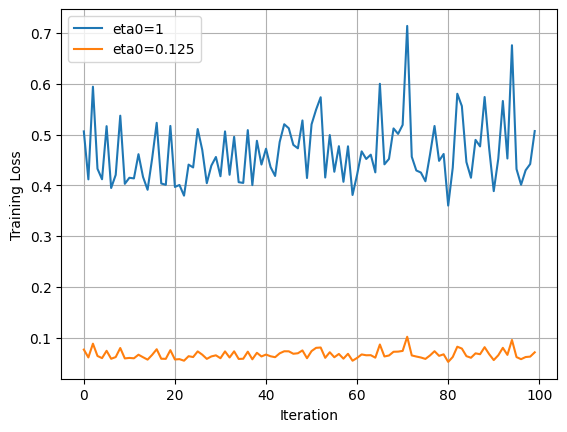

In [90]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1,label='eta0=1')
plt.plot(np.arange(iterations), Loss, label='eta0=0.125')
plt.grid(True)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

Well, instead of instantiating a Perceptron class with a new learning rate and
re-train the model, we could simply get the best_estimator from `GridSearchCV` as follows.

In [91]:
best_bin_clf = bin_clf_gscv.best_estimator_

In [92]:
y_hat_train_0 = bin_clf.predict(x_train)
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



# Visualizing weight vectors (Optional)

It will be interesting to look into the samples which are misclassified as False
Positives (that is, images that are not zero but classified as zero), and come up with some possible reasons.

In [93]:
# repeating the code for readabilituy
bin_clf = Perceptron(max_iter=100)
bin_clf.fit(x_train,y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)

In [95]:
#find the index of false positive samples
idx_n= np.where(y_train_0 ==- 1) # index of true -ve samples
idx_pred_p = np.where(y_hat_train_0 == 1) # index of predicted positive samples
idx_pred_n = np.where(y_hat_train_0 ==- 1) # index of predicted negative samples
idx_fp = np.intersect1d(idx_n, idx_pred_p)
idx_tn = np.intersect1d(idx_n, idx_pred_n)

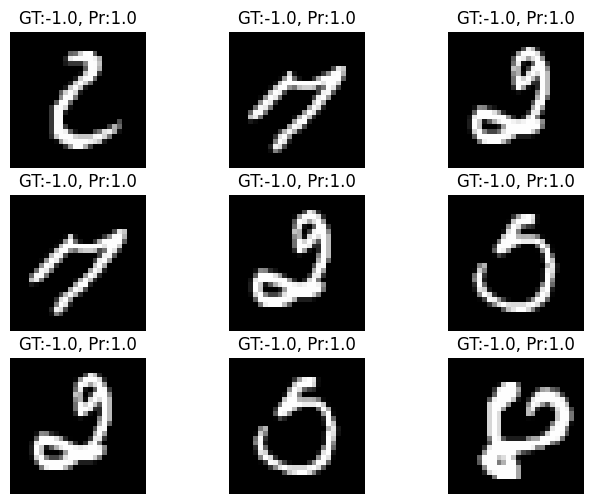

In [96]:
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0
for i in range(3):
    index = idx_offset+i
    for j in range(3):
        ax[i, j].imshow(x_train[idx_fp[index+j] ].reshape(28, 28) , cmap='gray' ) # we should not use x_train_with_dummy
        ax[i, j].set_title('GT:{0}, Pr:{1}'.format(str(y_train_0[idx_fp[index+j]]), str(y_hat_train_0[idx_fp[index+j]])))
        ax[i, j].set_axis_off()

We can do some reasoning if we look into what the perceptron is actually
learning about the digit 0 by visualizing the weight values after the training!

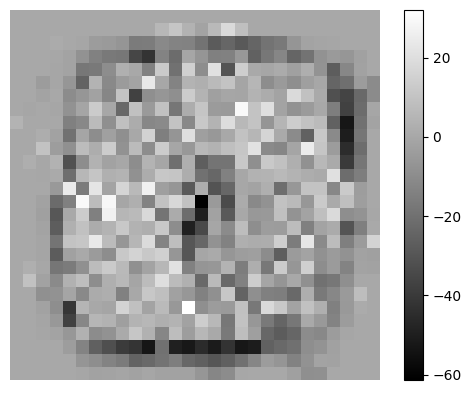

In [98]:
from matplotlib.colors import Normalize

w = bin_clf.coef_
w_matrix = w.reshape(28,28)
fig = plt.figure()
plt.imshow(w_matrix, cmap='gray')
plt.grid(False)
plt.axis(False)
plt.colorbar()
plt.show()

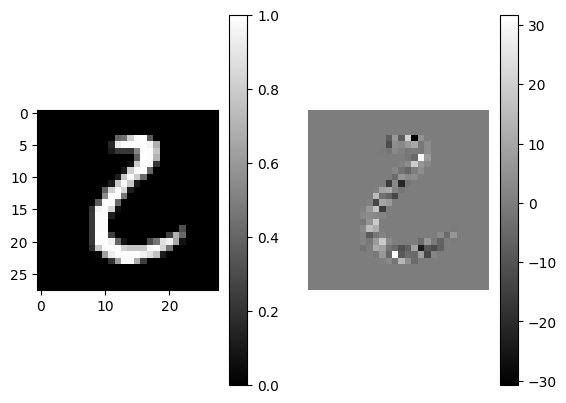

In [99]:
activation = w * x_train[idx_fp[0]].reshape(1,-1)
lin_out = activation.reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x_train[idx_fp[0]].reshape(28, 28) , cmap='gray')
plt.colorbar ()
# lin_out[lin_out<0]=0 #just set the value less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar ()
plt.grid(False)
plt.axis(False)
plt.show()

In [100]:
#input to the signum
print(np.sum(lin_out) + bin_clf.intercept_)

[22.90520569]


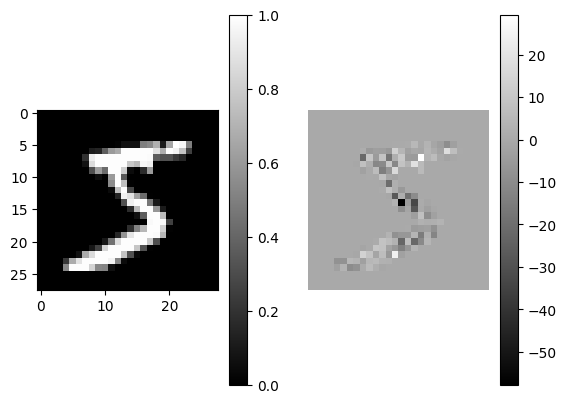

In [101]:
activation = w*x_train[idx_tn[0]].reshape(1,-1)
lin_out = activation.reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x_train[idx_tn[0] ]. reshape(28, 28) , cmap='gray')
plt.colorbar ()
# lin_out[lin_out<0]=0 #just set the value less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar ()
plt.grid(False)
plt.axis (False)
plt.show ()

In [102]:
#input to signum
print(np.sum(lin_out) + bin_clf.intercept_)

[-293.33960784]
